# Overview
- chapter03 のチップデータで遊ぶ

# Const

In [ ]:
cp = ['#f8b195', '#f67280', '#c06c84', '#6c5b7b', '#355c7d']
date_dict = {0:'thur', 1:'fri', 2:'sat', 3:'sun'}

# Import everything I need :)

In [2]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy import optimize

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# My function

# Preparation

set

In [3]:
plt.style.use('seaborn-darkgrid')

load datasets

In [4]:
tips = sns.load_dataset('tips')

# Do it

- レストランで客が払うチップの合計と曜日の関係
- 木金土日が入っている

In [5]:
tips.tail()

,total_bill,tip,sex,smoker,day,time,size
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
243,18.78,3.00,Female,No,Thur,Dinner,2


/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


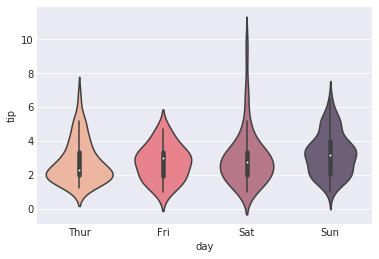

In [6]:
sns.violinplot(x='day', y='tip', data=tips, palette=cp)

> Sat は客がチップを多めに払う？

<br>

yとidx 変数の作成

idx は `Thur:0, Fri:1, Sat:2, Sun:3` となっている

In [7]:
tip_val = tips['tip'].values
idx = pd.Categorical(tips['day']).codes

<br>

今回知りたいのは、
**<font color='Orange'>チップの平均値の曜日依存</font>** ！！

- 曜日ごとにガウス分布でモデリングする。
- 平均値と標準偏差の事前分布をそれぞれ
**<font color="Skyblue">ガウス分布**</font>、 
**<font color="Skyblue">ハーフガウス分布**</font> とする。
- 標準偏差の事前分布がハーフガウス分布なのはもちろん標準偏差が非負値だから。　

<br>

modeling

In [8]:
with pm.Model() as comparing_groups:
    means = pm.Normal('means', mu=0, sd=10, shape=len(set(idx)))     # 平均値の事前分布
    sds = pm.HalfNormal('sds', sd=10, shape=len(set(idx)))           # 標準偏差の事後分布

    y = pm.Normal('y', mu=means[idx], sd=sds[idx], observed=tip_val) # 尤度

<br>

sampling

In [9]:
%%time
with comparing_groups:
    step = pm.NUTS() # NUTSでサンプリング
    trace_cg = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sds, means]
Sampling 4 chains, 0 divergences: 100%|██████████| 22000/22000 [00:08<00:00, 2449.54draws/s]


CPU times: user 9.07 s, sys: 581 ms, total: 9.65 s
Wall time: 13.3 s


<br>

事後分布のプロット

/home/user/.local/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/user/.local/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2291a5f0f0>,
      dtype=object)

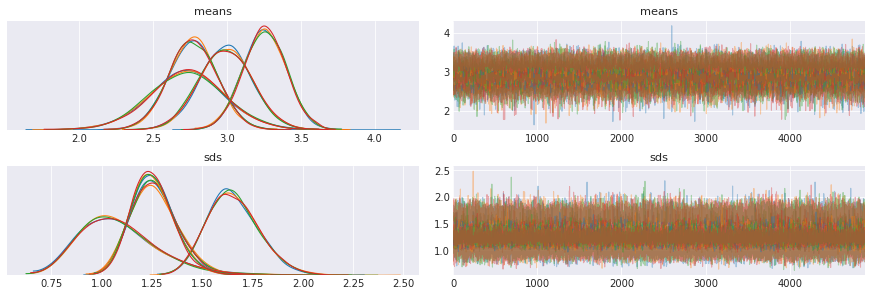

In [10]:
chain_cg = trace_cg[100::]
pm.traceplot(chain_cg)

> 事後分布が得られた。  
曜日ごとで`4つの`チェーンが得られた。　

<br>

summary

In [11]:
pm.summary(trace_cg)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
means[0],2.770,0.161,2.464,3.069,0.001,0.001,26143.0,26071.0,26219.0,15910.0,1.0
means[1],2.731,0.252,2.249,3.204,0.002,0.001,22256.0,22110.0,22599.0,14531.0,1.0
means[2],2.992,0.176,2.652,3.313,0.001,0.001,22760.0,22754.0,22823.0,14984.0,1.0
means[3],3.255,0.143,2.984,3.522,0.001,0.001,22727.0,22701.0,22733.0,16119.0,1.0
sds[0],1.265,0.116,1.057,1.485,0.001,0.001,22771.0,22019.0,23601.0,15427.0,1.0
sds[1],1.091,0.198,0.752,1.454,0.001,0.001,19777.0,17780.0,22476.0,13571.0,1.0
sds[2],1.655,0.128,1.421,1.894,0.001,0.001,21728.0,21098.0,22580.0,15144.0,1.0
sds[3],1.255,0.105,1.067,1.459,0.001,0.001,22596.0,21902.0,23407.0,14912.0,1.0


<br>

MAP値で観測データにフィットさせてみる
(samplingしなくてもできる)

In [24]:
with comparing_groups:
    map_infs = pm.find_MAP(fmin=optimize.fmin_powell)

/home/user/.local/lib/python3.6/site-packages/pymc3/tuning/starting.py:116: UserWarning: In future versions, set the optimization algorithm with a string. For example, use `method="L-BFGS-B"` instead of `fmin=sp.optimize.fmin_l_bfgs_b"`.
  "In future versions, set the optimization algorithm with a string. "
logp = -439.71:   5%|▍         | 249/5000 [00:00<00:01, 3359.34it/s]

Optimization terminated successfully.
         Current function value: 439.714394
         Iterations: 3
         Function evaluations: 249


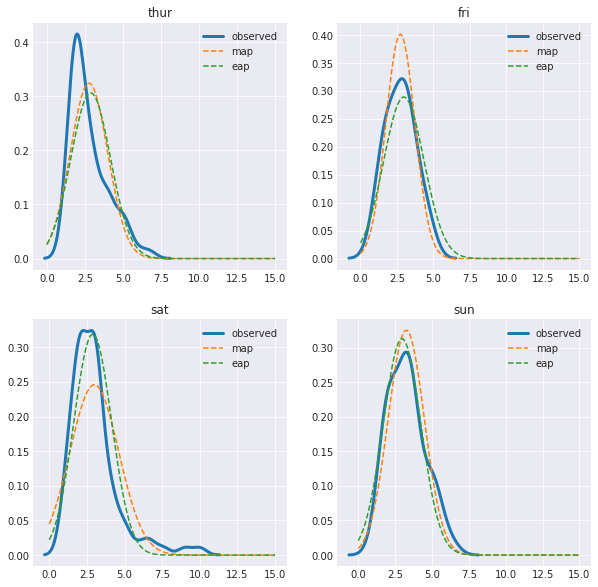

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
x = np.linspace(0, 15, 100)
axs = axs.ravel()

norm = stats.norm.pdf
for i in range(4):
    # map推定
    map_mean = map_infs['means'][i]
    map_sds = map_infs['sds'][i]
    map_norm_inf = norm(x, map_mean, map_sds)
    # 事後分布の平均値(EAP)
    eap_mean = chain_cg['means'][i].mean()
    eap_sds = chain_cg['sds'][i].mean()
    eap_norm_inf = norm(x, eap_mean, eap_sds)
    # plot
    sns.kdeplot(tip_val[idx==i], ax=axs[i], label='observed', lw=3)
    axs[i].plot(x, map_norm_inf, label='map', linestyle='--')
    axs[i].plot(x, eap_norm_inf, label='eap', linestyle='--')
    axs[i].legend()
    axs[i].set_title(date_dict[i])

> MAP推定はうまくいってるっぽい  
でもこれ、点推定だからあんまり意味ないよな...  
サンプリングの必要もないし

<br>

plot_posterioをつかう

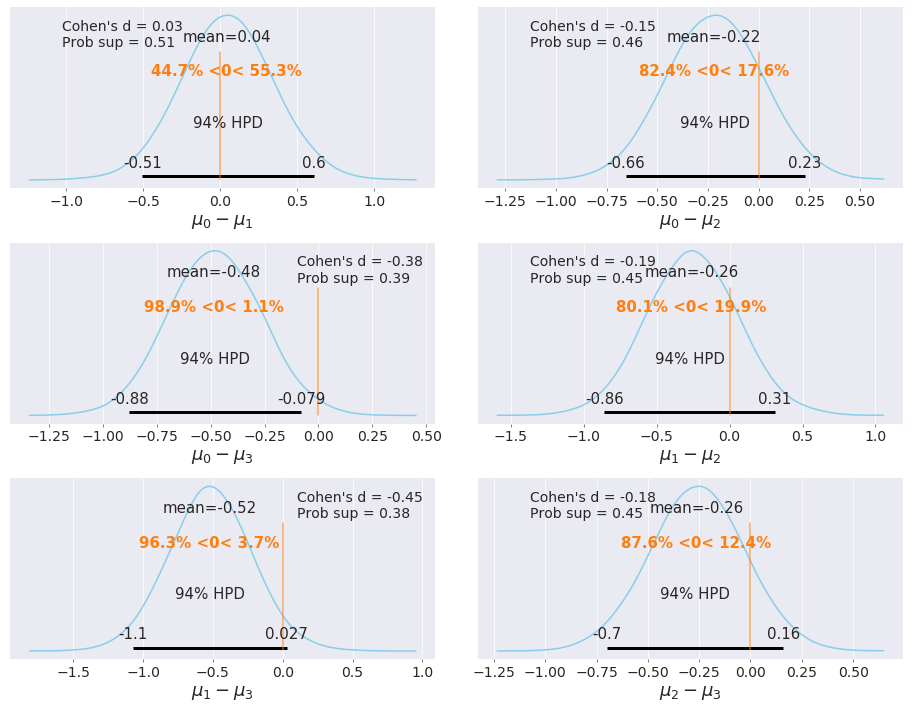

In [20]:
dist = dist = stats.norm()
_, ax = plt.subplots(3, 2, figsize=(16, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

comparisons = [(i,j) for i in range(4) for j in range(i+1, 4)]
pos = [(k,l) for k in range(3) for l in (0, 1)]

for (i,j), (k,l) in zip(comparisons, pos):
    means_diff = chain_cg['means'][:,i]-chain_cg['means'][:,j]
    d_cohen = (means_diff / np.sqrt((chain_cg['sds'][:,i]**2 + chain_cg['sds'][:,j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))

    pm.plot_posterior(means_diff, ref_val=0, ax=ax[k,l], color='skyblue')#, kde_plot=True)
    ax[k,l].plot(0, label="Cohen's d = {:.2f}\nProb sup = {:.2f}".format(d_cohen, ps), alpha=0)
    ax[k,l].set_xlabel('$\mu_{}-\mu_{}$'.format(i,j), fontsize=18)
    ax[k,l].legend(loc=0, fontsize=14)
    ax[k,l].set_title(None)

> $\mu_0 - \mu_3$ 以外HPD以内に収まってる。  
ベイズ的には$\mu_0 - \mu_3$ だけはっきりと違うらしい。